<a href="https://colab.research.google.com/github/smallcats/TopicalLanguageModels/blob/master/Neural_TLM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
import re

from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Lambda, Concatenate, Reshape, Dot
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback

from gensim.models import Word2Vec

from matplotlib import pyplot as plt

In [0]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
thurs = nltk.corpus.gutenberg.raw('chesterton-thursday.txt')
len(thurs)

320525

In [0]:
thurs = thurs.split('\n\n')
len(thurs)

1304

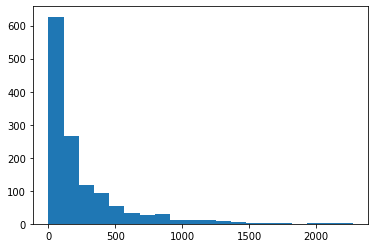

In [0]:
plt.hist([len(d) for d in thurs], bins=20)
plt.show()

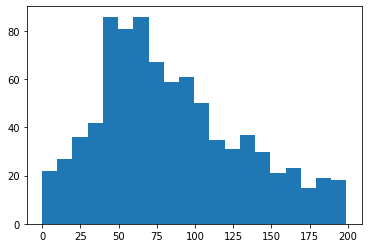

In [0]:
plt.hist([len(d) for d in thurs if len(d)<200], bins=20)
plt.show()

In [0]:
len([d for d in thurs if len(d)>75])

876

In [0]:
thurs = [d for d in thurs if len(d)>75]

In [0]:
thurs = [' '.join(d.split()) for d in thurs]

In [0]:
thurs[10]

'"Nonsense!" said Gregory, who was very rational when anyone else attempted paradox. "Why do all the clerks and navvies in the railway trains look so sad and tired, so very sad and tired? I will tell you. It is because they know that the train is going right. It is because they know that whatever place they have taken a ticket for that place they will reach. It is because after they have passed Sloane Square they know that the next station must be Victoria, and nothing but Victoria. Oh, their wild rapture! oh, their eyes like stars and their souls again in Eden, if the next station were unaccountably Baker Street!"'

In [0]:
thurs_sent = '\n'.join(thurs)
thurs_sent = nltk.tokenize.sent_tokenize(thurs_sent)

In [0]:
def doc2words(doc):
  words = nltk.tokenize.word_tokenize(doc)
  words = [w.lower() for w in words if w.isalpha()]
  words = [w for w in words if (len(w)>1) and (w not in stopwords)]
  return words

In [0]:
thurs_sent = [doc2words(s) for s in thurs_sent]

In [0]:
emb = Word2Vec(thurs_sent)

In [0]:
emb.wv.similar_by_word('door')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('face', 0.9969711899757385),
 ('found', 0.9969350695610046),
 ('syme', 0.9968661069869995),
 ('street', 0.9968335628509521),
 ('began', 0.996825098991394),
 ('professor', 0.9968061447143555),
 ('see', 0.9967728853225708),
 ('good', 0.9967683553695679),
 ('sunday', 0.9967629313468933),
 ('two', 0.9967553019523621)]

In [0]:
we = {w:emb.wv.get_vector(w) for w in emb.wv.vocab}
vec_size = emb.vector_size

In [0]:
def multiples(it, n):
  for k in range(len(it)-n+1):
    yield it[k:k+n]

class TLMDataGen:
  def __init__(self, documents, word_embedding, doc2words, lm_length, token2idx, 
               valid_num=None, valid_frac=None, batch_size=20, valid_batch_size=100):
    if valid_num is None and valid_frac is None:
      if len(documents) < 1000:
        valid_num = int(0.1*len(documents))
      else:
        valid_num = 100
    elif valid_num is None:
      valid_num = int(valid_frac*len(documents))

    perm = np.random.permutation(len(documents))
    self.train_idxs = perm[:valid_num]
    self.valid_idxs = perm[valid_num:]

    self.documents = documents
    self.batch_size = batch_size
    self.valid_batch_size = valid_batch_size
    self.word_embedding = word_embedding
    self.doc2words = doc2words
    self.lm_length = lm_length
    self.token2idx = token2idx

  def get_train_batch(self):
    doc_idxs = np.random.choice(self.train_idxs, size=self.batch_size)
    docs = [self.documents[k] for k in doc_idxs]
    finish_idxs = [np.random.randint(0, len(d)+1) for d in docs]
    
    x_topic = np.array([np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]).mean(axis=0) for d in docs])

    lm_docs = [d[max(i-self.lm_length,0):i] for i, d in zip(finish_idxs, docs)]
    x_lm = np.array([[0]*(self.lm_length - len(d))+[self.token2idx.get(t,2) for t in d] for d in lm_docs])

    y = np.array([self.token2idx.get(d[i],2) if i != len(d) else 1 for i,d in zip(finish_idxs, docs)])
    
    return [x_topic, x_lm], y

  def get_valid_batch(self):
    doc_idxs = np.random.choice(self.valid_idxs, size=self.valid_batch_size)
    docs = [self.documents[k] for k in doc_idxs]
    finish_idxs = [np.random.randint(0, len(d)+1) for d in docs]
    
    x_topic = np.array([np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]).mean(axis=0) for d in docs])

    lm_docs = [d[max(i-self.lm_length,0):i] for i, d in zip(finish_idxs, docs)]
    x_lm = np.array([[0]*(self.lm_length - len(d))+[self.token2idx.get(t,2) for t in d] for d in lm_docs])

    y = np.array([self.token2idx.get(d[i],2) if i != len(d) else 1 for i,d in zip(finish_idxs, docs)])
    
    return [x_topic, x_lm], y



class TopicalLanguageModel:
  """
  Neural Topical Language Model.

  attributes:
  num_topics :: int : number of topics
  doc2words :: function : takes a document as a string and returns words
  word_embedding :: dict : keys are words, values are vectors
  vector_size :: int : the dimension of embedding vectors
  lm_length :: int : length of tokens taken into account for character-level language models 
  """
  def __init__(self, num_topics, word_embedding, vector_size, doc2words, lm_length=30, tokens='abcdefghijklmnopqrstuvwxyz '):
    self.num_topics = num_topics
    self.doc2words = doc2words
    self.word_embedding = word_embedding
    self.vector_size = vector_size
    self.lm_length = lm_length

    self.tokens = ['<', '>', '*'] + list(tokens)
    token_idx = [(t, k+3) for k,t in enumerate(list(tokens))] # 0 = start, 1 = end, 2 = unknown
    self.token2idx = {t:k for t,k in token_idx}
    self.idx2token = {k:t for t,k in token_idx}

    self.num_tokens = len(tokens)+3

  def fit(self, documents, batch_size=20, epochs=10, verbose=0, examples_per_epoch=5, example_epoch_skip=1, num_validation_samples=5):
    """
    fit(self, documents)

    documents should be a list of sentences, and a sentence a list of words.
    """
    x_topic = Input(shape=(self.vector_size,))
    h_topic = Dense(self.vector_size, activation='relu')(x_topic)
    out_topic = Dense(self.num_topics, activation='softmax')(h_topic)
    self.topic_model = Model(inputs=[x_topic], outputs=out_topic)
    
    self.language_models = []
    for k in range(self.num_topics):
      x_lm = Input(shape=(self.lm_length,), dtype='int32')
      h_lm = Embedding(input_dim=self.num_tokens, output_dim=self.num_tokens//2, input_length=self.lm_length)(x_lm)
      h_lm = LSTM(self.num_tokens)(h_lm)
      out_lm = Dense(self.num_tokens, activation='softmax')(h_lm)
      lm = Model(inputs=[x_lm], outputs=out_lm)
      self.language_models.append(lm)

    train_topic_input = Input(shape=(self.vector_size,))
    train_lm_input = Input(shape=(self.lm_length,), dtype='int32')

    lm_outputs = [Reshape(target_shape=(self.num_tokens, 1))(lm(train_lm_input)) for lm in self.language_models]
    lm_outputs = Concatenate(axis=2)(lm_outputs)
    topic_mix = self.topic_model(train_topic_input)

    out = Dot(axes=(2, 1))([lm_outputs, topic_mix])

    self.train_model = Model(inputs=[train_topic_input, train_lm_input], outputs=out)
    self.train_model.compile('adam', 'sparse_categorical_crossentropy')

    data_generator = TLMDataGen(documents, word_embedding=self.word_embedding, 
                                doc2words=self.doc2words, 
                                lm_length=self.lm_length, 
                                token2idx=self.token2idx,
                                batch_size = batch_size)

    steps_per_epoch = len(documents)//batch_size
    self.logs = {'examples':[], 'val_loss':[], 'topic_fraction':[], 'topic_entropy':[]}
    for epoch in range(epochs+1):

      #examples
      if epoch%example_epoch_skip == 0:
        if verbose>1:
          print('Getting examples')
        for t in range(self.num_topics):
          for k in range(examples_per_epoch):
            self.logs['examples'].append((self.rollout('', topic=t, maxlen=100), t, epoch))

      #validation loss
      if verbose>1:
        print('Running validation loss')
      losses = [self.train_model.test_on_batch(*(data_generator.get_valid_batch())) for k in range(num_validation_samples)]
      self.logs['val_loss'].append(losses)

      #topics
      if verbose>1:
        print('Getting topic distributions')
      xs, y = data_generator.get_valid_batch()
      x = xs[0]
      topics = self.topic_model.predict(x)
      entropies = (-topics*np.log(topics)).sum(axis=1)
      mean_entropy = entropies.mean(axis=0)
      std_entropy = entropies.std(axis=0)
      mean_topics = topics.mean(axis=0)
      self.logs['topic_fraction'].append(mean_topics)
      self.logs['topic_entropy'].append((mean_entropy, std_entropy))

      if epoch<epochs:
        #train
        if verbose>1:
          print('Training')
        avg_loss = 0
        for step in range(steps_per_epoch):
          xs, y = data_generator.get_train_batch()
          avg_loss = (step/(step+1))*avg_loss + self.train_model.train_on_batch(xs, y)/(step+1)
        #print
        if verbose > 0:
          print('Epoch {0} - Avg train loss: {1}'.format(epoch, avg_loss))
      
  def predict(self, init_doc, topic, method='sample'):
    idx_doc = [self.token2idx.get(c,2) for c in init_doc]
    dlen = len(idx_doc)
    if dlen < self.lm_length:
      idx_doc = [0]*(self.lm_length-dlen)+idx_doc
    elif dlen > self.lm_length:
      idx_doc = idx_doc[-self.lm_length:]

    probs = self.language_models[topic].predict(np.array(idx_doc).reshape((1,-1)))[0]

    if method == 'sample':
      return np.random.choice(self.tokens, p=probs)

    elif method == 'max':
      return self.tokens[np.argmax(probs)]

    elif method == 'distribution':
      return probs

    else:
      raise ValueError('Unknown method.')

  def rollout(self, init_doc, topic, method='monte-carlo', maxlen=100):
    pred_method = 'sample' if method=='monte-carlo' else 'max' if method=='greedy' else ''
    
    for k in range(maxlen-len(init_doc)):
      predicted = self.predict(init_doc, topic, pred_method)
      if predicted == '>': break
      init_doc = init_doc + predicted

    return init_doc

  def get_topics(self, doc):
    words = self.doc2words(doc)
    embedding = np.array([self.word_embedding[w] for w in words if w in self.word_embedding]).mean(axis=0)
    return self.topic_model.predict(embedding.reshape((-1,1)))[0]

In [0]:
tlm = TopicalLanguageModel(num_topics=2, word_embedding=emb, vector_size=vec_size, doc2words=doc2words)

In [0]:
tlm.fit(thurs, epochs=100, verbose=1, example_epoch_skip=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launc

Epoch 0 - Avg train loss: 3.3058412296827435


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Epoch 1 - Avg train loss: 2.9425457799157435
Epoch 2 - Avg train loss: 2.9424513827922727
Epoch 3 - Avg train loss: 2.8691119149673825
Epoch 4 - Avg train loss: 2.9170321697412516
Epoch 5 - Avg train loss: 2.8854052466015485
Epoch 6 - Avg train loss: 2.95758575062419
Epoch 7 - Avg train loss: 2.8629996832026987
Epoch 8 - Avg train loss: 2.8784987205682797
Epoch 9 - Avg train loss: 2.8165580283763805
Epoch 10 - Avg train loss: 2.8350121864052706
Epoch 11 - Avg train loss: 2.8141221667444993
Epoch 12 - Avg train loss: 2.737226996310922
Epoch 13 - Avg train loss: 2.6685792679010425
Epoch 14 - Avg train loss: 2.7002792358398438
Epoch 15 - Avg train loss: 2.5846986992414607
Epoch 16 - Avg train loss: 2.608069483623947
Epoch 17 - Avg train loss: 2.548862468364627
Epoch 18 - Avg train loss: 2.5305784413980876
Epoch 19 - Avg train loss: 2.4827486747919134
Epoch 20 - Avg train loss: 2.5120730871377983
Epoch 21 - Avg train loss: 2.4751588217047753
Epoch 22 - Avg train loss: 2.518752497296001
Epo

In [0]:
tlm.logs.keys()

dict_keys(['examples', 'val_loss', 'topic_fraction', 'topic_entropy'])

In [0]:
pd.set_option('display.max_colwidth', -1)
ex = pd.DataFrame(columns=['example', 'topic_num', 'epoch'], data=tlm.logs['examples'])
ex.sample(10).sort_values('epoch')

,example,topic_num,epoch
19,o*t a*rolath* rrrl kgdf aisan*chqe arpidle bncai m e yotieieast *a eipbhgest uih tne qg *a a m a,1,10
17,tytd ne je rusltee*stcye o braeaath sh tp tehemhh*r**hnhhy oh teeffh uavseasrnoheseis r*ao*m*h,1,10
11,nrh hri nu id iahdeeohaontote dtemik ohom omal*ooso hdii*woctodiph*qderdoo nndhud mp*o* lebo h hmu,0,10
32,meukf** osordhen narthinde* d* anr*,0,30
38,*afplcese ori otgls *rr bere* uce tumt ar taln ce *ve tfr ces afeile bttela fhe ary ln lpslplte re h,1,30
37,behe rbere* * *aransee urel mce *ka ban bhe aon tuwtft t lre *re cef tre faduiptchate tt fteea nfr *,1,30
44,** do ud honrt annliidt he hin videng*** ind ppaes pawhey* ort esonme*n,0,40
54,shanind he thayd iry* hinu*t pome* soros*** nhand ide mipad battso kot tho cheninmety ins vot thast,0,50
51,*** ppyansshicaypermthink higw towhis*og and had avoags ath iryh it his tomr and ouh ound let pidy*,0,50
74,** canyt samth* and *amt**,0,70


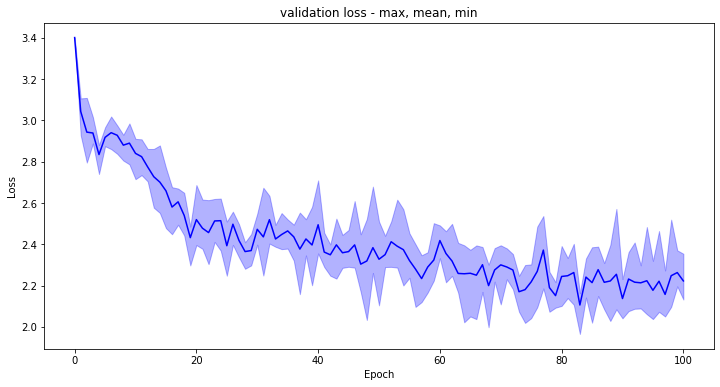

In [0]:
mean_losses = [np.array(v).mean() for v in tlm.logs['val_loss']]
max_losses = [np.array(v).max() for v in tlm.logs['val_loss']]
min_losses = [np.array(v).min() for v in tlm.logs['val_loss']]
epoch = np.arange(len(mean_losses))

fig, ax = plt.subplots()
ax.plot(epoch, mean_losses, color='b')
ax.fill_between(epoch, max_losses, min_losses, color='b', alpha=0.3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

fig.set_size_inches(12,6)
plt.title('validation loss - max, mean, min')

plt.show()

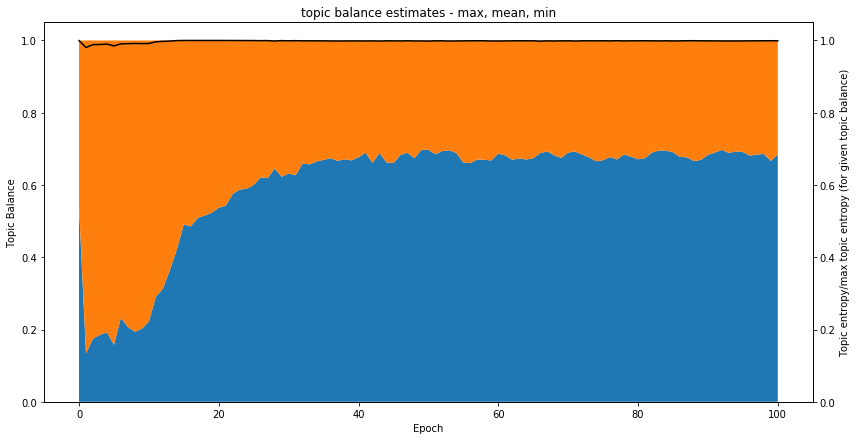

In [0]:
epoch = np.arange(len(tlm.logs['topic_entropy']))

fig, ax_mean = plt.subplots()
ax_mean.stackplot(epoch, np.array(tlm.logs['topic_fraction']).T)
ax_mean.set_xlabel('Epoch')
ax_mean.set_ylabel('Topic Balance')

ax_ent = ax_mean.twinx()
topic_entropy = [e[0] for e in tlm.logs['topic_entropy']]
max_topic_entropy = [(-p*np.log(p)).sum() for p in tlm.logs['topic_fraction']]
frac_topic_entropy = [e/m for e,m in zip(topic_entropy, max_topic_entropy)]
ax_ent.plot(epoch, frac_topic_entropy, color='k')
ax_ent.set_ylabel('Topic entropy/max topic entropy (for given topic balance)')
ax_ent.set_ylim(0,1.05)

fig.set_size_inches(12,6)
fig.tight_layout()
plt.title('topic balance estimates - max, mean, min')

plt.show()

In [0]:
tlm.logs['topic_entropy']

[(0.68955266, 0.0017217952),
 (0.38591203, 0.07646486),
 (0.4578724, 0.06147521),
 (0.47416934, 0.058861084),
 (0.48409832, 0.05722094),
 (0.42930135, 0.067985274),
 (0.5368773, 0.050912954),
 (0.50532603, 0.053238306),
 (0.48772725, 0.051488932),
 (0.4987886, 0.05262982),
 (0.5254823, 0.049665008),
 (0.6008255, 0.027924955),
 (0.62013656, 0.020574616),
 (0.6547322, 0.014196348),
 (0.6805907, 0.0030307455),
 (0.69298303, 1.9308958e-05),
 (0.6927298, 5.959799e-05),
 (0.6929777, 5.633437e-06),
 (0.6926596, 1.1250239e-05),
 (0.69205576, 3.6079284e-05),
 (0.6903935, 0.00023009774),
 (0.6894937, 0.00033303566),
 (0.68171495, 0.0016824896),
 (0.6777128, 0.0025792145),
 (0.6768548, 0.002960642),
 (0.6727418, 0.0038168796),
 (0.66326654, 0.0065445313),
 (0.6642511, 0.0053688493),
 (0.64935666, 0.014519419),
 (0.6624683, 0.005689453),
 (0.65736246, 0.009880883),
 (0.6602642, 0.006912502),
 (0.6406902, 0.011487922),
 (0.6423857, 0.011287411),
 (0.63698506, 0.011556741),
 (0.63366556, 0.012838392